In [2]:
model_path = "./Model/google-epoch=14-val_acc=0.96.ckpt"

In [3]:
import torch
import torchvision.models as models
import pytorch_lightning as pl
from torchmetrics import Accuracy

# Define the Lightning wrapper (your class)
class ClassificationLitModuleGoogle(pl.LightningModule):
    def __init__(self, model, lr=1e-3, num_classes=None, use_aux_loss=True):
        super().__init__()
        self.model = model
        self.lr = lr
        self.criterion = torch.nn.CrossEntropyLoss()
        nc = num_classes or getattr(model, 'num_classes', None) or 30
        self.num_classes = nc
        self.train_acc = Accuracy(task='multiclass', num_classes=nc)
        self.val_acc = Accuracy(task='multiclass', num_classes=nc)
        self.test_acc = Accuracy(task='multiclass', num_classes=nc)
        self.use_aux_loss = use_aux_loss

    def forward(self, x):
        outputs = self.model(x)
        if hasattr(outputs, 'logits'):
            return outputs.logits
        return outputs

In [4]:
# Instantiate the base GoogLeNet model
googlenet_model = models.googlenet(pretrained=True, aux_logits=True)
num_classes = 30  # change this to match your fruit classes
googlenet_model.fc = torch.nn.Linear(1024, num_classes)  # update final layer

# Instantiate Lightning module
lit_model = ClassificationLitModuleGoogle(googlenet_model, num_classes=num_classes)

# Load checkpoint
checkpoint = torch.load(model_path, map_location='cpu')
lit_model.load_state_dict(checkpoint['state_dict'], strict=False)
lit_model.eval()

C:\Users\berin\PycharmProjects\Lateral_Internship\Task10\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\berin\PycharmProjects\Lateral_Internship\Task10\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\berin/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:05<00:00, 10.4MB/s]
C:\Users\berin\PycharmProjects\Lateral_Internship\Task10\.venv\Lib\site-packages\torchvision\models\googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


ClassificationLitModuleGoogle(
  (model): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [5]:
from pydantic import BaseModel

class PlantCareCard(BaseModel):
    common_name: str
    latin_name: str
    care_difficulty: str
    watering_frequency: str
    sunlight: str
    soil_type: str
    fertilizer: str
    outdoors: bool
    notes: str

In [6]:
plant_prompt_template = """
You are a world-class botanist and horticulturist.
You generate expert Plant Care Cards for any plant species.

Return your answer strictly as a JSON object with the EXACT schema:

{{
  "common_name": "string",
  "latin_name": "string",
  "care_difficulty": "string",
  "watering_frequency": "string",
  "sunlight": "string",
  "soil_type": "string",
  "fertilizer": "string",
  "outdoors": true,
  "notes": "string"
}}

All fields are REQUIRED.

Plant name: "{plant_name}"
"""



In [7]:
from openai import OpenAI
import json

client = OpenAI(api_key="GPT_API_KEY")

def generate_plant_card(plant_name: str) -> PlantCareCard:
    prompt = plant_prompt_template.format(plant_name=plant_name)

    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[
            {"role": "system", "content": "You generate structured plant care data."},
            {"role": "user", "content": prompt}
        ],
        response_format={"type": "json_object"},
    )

    raw_json = response.choices[0].message.content
    return PlantCareCard(**json.loads(raw_json))

In [8]:
def load_image_from_url(url: str):
    response = requests.get(url)
    response.raise_for_status()
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img

In [9]:
from PIL import Image
import torch
from torchvision import transforms

labels = [  # your 30 labels
    "aloevera","banana","bilimbi","cantaloupe","cassava","coconut","corn","cucumber","curcuma",
    "eggplant","galangal","ginger","guava","kale","longbeans","mango","melon","orange","paddy",
    "papaya","peper chili","pineapple","pomelo","shallot","soybeans","spinach","sweet potatoes",
    "tobacco","waterapple","watermelon"
]


def classify_image(url):
    img = load_image_from_url(url)

    IMG_SIZE = 224

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    img_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        logits = lit_model(img_tensor)
        pred_idx = torch.argmax(logits, dim=1).item()

    return labels[pred_idx]

def full_pipeline(image_url):
    # Step 1 → classify plant
    plant_label = classify_image(image_url)
    print("Predicted plant:", plant_label)

    # Step 2 → generate plant care card using GPT
    card = generate_plant_card(plant_label)

    plot_plant_card(image_url, card)

In [10]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

def plot_plant_card(image_url, card: PlantCareCard):
    # Load image
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert("RGB")

    # Set up figure
    fig, ax = plt.subplots(figsize=(6, 8))
    ax.axis('off')  # hide axes

    # Display image
    ax.imshow(img)

    # Prepare text
    text = f"""
Common Name: {card.common_name}
Latin Name: {card.latin_name}
Care Difficulty: {card.care_difficulty}
Watering: {card.watering_frequency}
Sunlight: {card.sunlight}
Soil Type: {card.soil_type}
Fertilizer: {card.fertilizer}
Outdoors: {'Yes' if card.outdoors else 'No'}
Notes: {card.notes}
"""

    # Add text below the image
    plt.figtext(0.5, 0.02, text, wrap=True, horizontalalignment='center', fontsize=10, va='bottom')

    plt.tight_layout()
    plt.show()


Predicted plant: orange


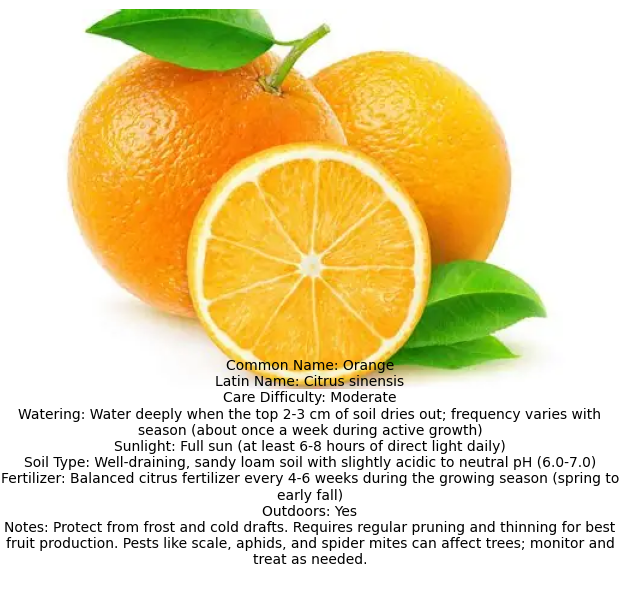

In [11]:
full_pipeline("https://th.bing.com/th/id/OIP.0fZotuI9AEs_qQjfumGfNgHaE8?w=287&h=191&c=7&r=0&o=7&dpr=1.8&pid=1.7&rm=3")